In [ ]:
# Imports
import aiohttp
import database
import matplotlib.pyplot as plt
from moviedata import movie_crawl
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [6]:
# Crawl Letterboxd
user = "pbreck"
async with aiohttp.ClientSession() as session:
    user_df = await movie_crawl(user, session)

Leave the World Behind
Society of the Snow
Priscilla
Poor Things
All of Us Strangers
Saltburn
Oppenheimer
Killers of the Flower Moon
Bottoms
Theater Camp
Dune
Knives Out
Midsommar
Parasite
Hereditary
Lady Bird
The Florida Project
Get Out
Call Me by Your Name
The Age of Adaline
Gone Girl
The Grand Budapest Hotel
Black Swan
Fantastic Mr. Fox
(500) Days of Summer
Pride & Prejudice
The Notebook
The Virgin Suicides
Priscilla is not rated by pbreck
Lady Bird is not rated by pbreck
The Virgin Suicides is not rated by pbreck
Leave the World Behind is not rated by pbreck
Bottoms is not rated by pbreck
Parasite is not rated by pbreck
Fantastic Mr. Fox is not rated by pbreck
Pride & Prejudice is not rated by pbreck
Gone Girl is not rated by pbreck
Hereditary is not rated by pbreck
Call Me by Your Name is not rated by pbreck
Knives Out is not rated by pbreck
The Grand Budapest Hotel is not rated by pbreck
Black Swan is not rated by pbreck
Get Out is not rated by pbreck
Midsommar is not rated by pb

In [28]:
# Model Evaluation
def train_model(user_df, modelType="XGBoost", verbose=False):

    # creates user feature data
    X = user_df.drop(columns=["title", "user_rating"])

    # creates user target data
    y = user_df["user_rating"]

    # creates train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0
    )

    # creates test-validation split
    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, random_state=0
    )

    # initializes recommendation model
    if modelType == "XG":
        model = XGBRegressor(enable_categorical=True)
    elif modelType == "RF":
        model = RandomForestRegressor()
    elif modelType == "SVR":
        model = SVR()

    # performs k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    cv_results = cross_val_score(
        model, X_train, y_train, cv=kf, scoring="neg_mean_squared_error"
    )
    mse_cv = -cv_results.mean()

    # fits recommendation model on user training data
    model.fit(X_train, y_train)

    # calculates mse on test data
    y_pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # calculates mse on validation data
    y_pred_val = model.predict(X_val)
    mse_val = mean_squared_error(y_val, y_pred_val)

    results_df = pd.DataFrame(
        {"actual_user_rating": y_val, "predicted_user_rating": y_pred_val.flatten()}
    )

    # prints accuracy evaluation values
    if verbose:
        print("Mean Squared Error with 5-fold Cross Validation:", mse_cv)
        print("Mean Squared Error on Test Set:", mse_test)
        print("Mean Squared Error on Validation Set:", mse_val)
        print(results_df)

    return model, mse_cv, mse_test, mse_val


def single_user_evaluation(user, modelType):
    user = "victorverma"
    user_df = database.get_user_data(user, modelType)
    train_model(user_df, verbose=True)


def all_user_evaluation(modelType):

    # gets list of users from database
    users = database.get_users_in_db()

    # calculates mses for cross-val, test, and val for each model
    cv_mses = []
    test_mses = []
    val_mses = []
    for user in users:
        user_df = database.get_user_data(user)
        _, mse_cv, mse_test, mse_val = train_model(user_df, modelType)
        cv_mses.append(mse_cv)
        test_mses.append(mse_test)
        val_mses.append(mse_val)

    # adds row containing average
    users.append("average")
    cv_mses.append(np.mean(cv_mses))
    test_mses.append(np.mean(test_mses))
    val_mses.append(np.mean(val_mses))

    # adds row containing std
    users.append("std")
    cv_mses.append(np.std(cv_mses))
    test_mses.append(np.std(test_mses))
    val_mses.append(np.std(val_mses))

    # stores accuracy evaluations in dataframe
    accuracy_df = pd.DataFrame(
        {
            "User": users,
            f"{modelType} Cross-Val MSE": cv_mses,
            f"{modelType} Test MSE": test_mses,
            f"{modelType} Val MSE": val_mses,
        }
    )

    return accuracy_df


def plot_accuracies(distributions):
    x = np.linspace(0, 2, 1000)

    # plots overlay of test mse pdfs and val mse pdfs for all models
    for plotOf in ["cross_val", "test", "val"]:
        plt.figure(figsize=(6, 3))
        for model, mse_data in distributions.items():
            mse_mean = np.mean(mse_data[f"{plotOf}_mse"])
            mse_std = np.std(mse_data[f"{plotOf}_mse"])
            mse_pdf = (1 / (mse_std * np.sqrt(2 * np.pi))) * np.exp(
                -((x - mse_mean) ** 2) / (2 * mse_std**2)
            )
            plt.plot(x, mse_pdf, label=model + f" {plotOf.title()} MSE")

        plt.title(f"Normal Distribution of {plotOf.title()} MSE for Each Model")
        plt.xlabel(f"{plotOf.title()} MSE")
        plt.ylabel("Probability Density")
        plt.legend()
        plt.grid(True)
        plt.show()


def all_user_all_model_evaluation():
    modelTypes = ["XG", "RF", "SVR"]

    # initialize empty distributions
    distributions = {
        "XG": {"cross_val_mse": (), "test_mse": (), "val_mse": ()},
        "RF": {"cross_val_mse": (), "test_mse": (), "val_mse": ()},
        "SVR": {"cross_val_mse": (), "test_mse": (), "val_mse": ()},
    }
    for m in modelTypes:

        # gets the accuracy values of a particular model for all users
        accuracy_df = all_user_evaluation(m)

        # stores mean and std of cross-val mse
        cross_val_mean = (
            accuracy_df[accuracy_df["User"] == "average"][f"{m} Cross-Val MSE"],
        )
        cross_val_std = (
            accuracy_df[accuracy_df["User"] == "std"][f"{m} Cross-Val MSE"],
        )
        distributions[m]["cross_val_mse"] = (cross_val_mean, cross_val_std)

        # stores mean and std of test mse
        test_mean = (accuracy_df[accuracy_df["User"] == "average"][f"{m} Test MSE"],)
        test_std = (accuracy_df[accuracy_df["User"] == "std"][f"{m} Test MSE"],)
        distributions[m]["test_mse"] = (test_mean, test_std)

        # stores mean and std of val mse
        val_mean = (accuracy_df[accuracy_df["User"] == "average"][f"{m} Val MSE"],)
        val_std = (accuracy_df[accuracy_df["User"] == "std"][f"{m} Val MSE"],)
        distributions[m]["val_mse"] = (val_mean, val_std)

    # plots the accuracy evaluation values for all distributions
    plot_accuracies(distributions)

    return distributions


# single_user_evaluation("victorverma", "XG")
# print(all_user_evaluation("RF"))

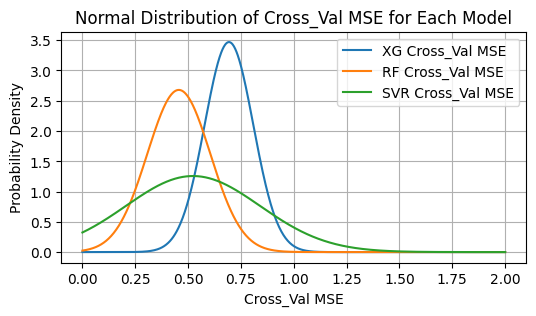

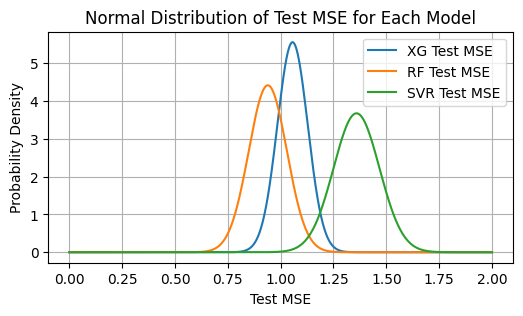

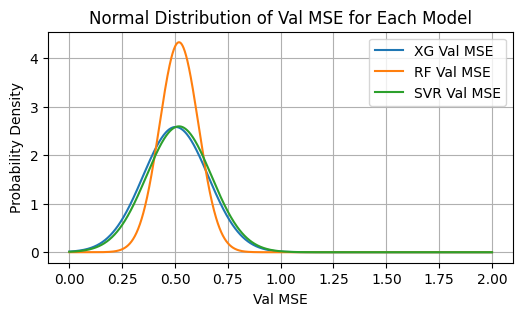

{'XG': {'cross_val_mse': ((11    0.808457
    Name: XG Cross-Val MSE, dtype: float64,),
   (12    0.578427
    Name: XG Cross-Val MSE, dtype: float64,)),
  'test_mse': ((11    0.984492
    Name: XG Test MSE, dtype: float64,),
   (12    1.128086
    Name: XG Test MSE, dtype: float64,)),
  'val_mse': ((11    0.65757
    Name: XG Val MSE, dtype: float64,),
   (12    0.348427
    Name: XG Val MSE, dtype: float64,))},
 'RF': {'cross_val_mse': ((11    0.605069
    Name: RF Cross-Val MSE, dtype: float64,),
   (12    0.307191
    Name: RF Cross-Val MSE, dtype: float64,)),
  'test_mse': ((11    0.848904
    Name: RF Test MSE, dtype: float64,),
   (12    1.029564
    Name: RF Test MSE, dtype: float64,)),
  'val_mse': ((11    0.611259
    Name: RF Val MSE, dtype: float64,),
   (12    0.426881
    Name: RF Val MSE, dtype: float64,))},
 'SVR': {'cross_val_mse': ((11    0.8407
    Name: SVR Cross-Val MSE, dtype: float64,),
   (12    0.205536
    Name: SVR Cross-Val MSE, dtype: float64,)),
  'test_ms

In [29]:
all_user_all_model_evaluation()